In [1]:
import pickle5 as pickle
import pandas as pd
import yfinance as yf
import pandas_ta as ta
import numpy as np

In [2]:
#lstm generator architecture
from torch import nn
from torch.nn.utils import spectral_norm


class AddDimension(nn.Module):
    def forward(self, x):
        return x.unsqueeze(1)


class SqueezeDimension(nn.Module):
    def forward(self, x):
        return x.squeeze(1)

#Banushev
# def create_critic_architecture():
#     return nn.Sequential(nn.Conv1d(1, 32, kernel_size=1, stride=2),
#     nn.LeakyReLU(0.01),
#     nn.Conv1d(32, 64, kernel_size=1, stride=2),
#     nn.LeakyReLU(0.01),
#     nn.BatchNorm1d(64),
#     nn.Conv1d(64, 128, kernel_size=1, stride=2),
#     nn.LeakyReLU(0.01),
#     nn.BatchNorm1d(128),
#     nn.Linear (128, 220, bias=False), nn.BatchNorm1d(220), nn.LeakyReLU(0.01),
#     nn.Linear (220, 220, bias=False), nn.ReLU(),
#     nn.Linear(220, 1))
                         

def create_critic_architecture():
    return nn.Sequential(AddDimension(),
                         spectral_norm(nn.Conv1d(1, 32, 3, padding=1), n_power_iterations=10),
                         nn.LeakyReLU(0.2, inplace=True),
                         
                         
                         spectral_norm(nn.Conv1d(32, 32, 3, padding=1), n_power_iterations=10),
                         nn.LeakyReLU(0.2, inplace=True),
                         

                         spectral_norm(nn.Conv1d(32, 32, 3, padding=1), n_power_iterations=10),
                         nn.LeakyReLU(0.2, inplace=True),
                         nn.Flatten(),

                         nn.Linear(32, 50),
                         nn.LeakyReLU(0.2, inplace=True),

                         nn.Linear(50, 15),
                         nn.LeakyReLU(0.2, inplace=True),

                         nn.Linear(15, 1)
                         )


class Generator(nn.Module):
    def __init__(self, num_embed=7, num_hidden=500, num_layers=1, sequence_length=1, output_size = 1, bidirectional=False):
        
        nn.Module.__init__(self)
        
        self.num_hidden = num_hidden
        
        self.rnn = nn.LSTM(num_embed, num_hidden, num_layers, bidirectional=bidirectional)
        self.decoder = nn.Linear(num_hidden, output_size)
    
    def forward(self, inputs):
        output, hidden = self.rnn(inputs)
        decoded = self.decoder(output)
        return decoded
    


class Critic(nn.Module):
    def __init__(self):
        nn.Module.__init__(self)
        self.main = create_critic_architecture()

    def forward(self, inputs):
        return self.main(inputs)

In [ ]:
data_final

In [3]:
data_final = pd.read_pickle('df_final.pkl')

In [4]:
data_final = data_final.drop(['3_day_ret', '7_day_ret', '14_day_ret', '21_day_ret', '28_day_ret'], axis=1)

In [5]:
data_final = data_final[['VADER_neg','VADER_neu', 'VADER_pos', 'VADER_compound', 
                                    'finBERT_pos', 'finBERT_neg', 'finBERT_neu', '1_day_ret']]

In [6]:
#turn data into their format
data_final_list = []
example_size = 1
for i in range (data_final.shape[0]-example_size):
    example = data_final.iloc[i:example_size+i].to_dict('series')
    for key in example.keys():
        example[key] = example[key].astype('float').to_list()
    data_final_list.append(example)

In [11]:
len(data_final_list)

293

In [7]:
train_data_proportion = int(.8*len(data_final_list))
train_data = data_final_list[:train_data_proportion]
test_data = data_final_list[train_data_proportion:]

In [8]:
import argparse
import os


import torch
from tqdm import tqdm
from torch.autograd import Variable
from torch.autograd import grad as torch_grad
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader
from math import pi

In [43]:
from sklearn.metrics import mean_absolute_error
class Trainer:
    NOISE_LENGTH = 50

    def __init__(self, generator, critic, gen_optimizer, critic_optimizer,
                 gp_weight=10, critic_iterations=5, print_every=50, use_cuda=False, checkpoint_frequency=200):
        self.g = generator
        self.g_opt = gen_optimizer
        self.c = critic
        self.c_opt = critic_optimizer
        self.losses = {'g': [], 'c': [], 'GP': [], 'gradient_norm': []}
        self.num_steps = 0
        self.use_cuda = use_cuda
        self.gp_weight = gp_weight
        self.critic_iterations = critic_iterations
        self.print_every = print_every
        self.checkpoint_frequency = checkpoint_frequency

        if self.use_cuda:
            self.g.cuda()
            self.c.cuda()

    def _critic_train_iteration(self, data):
    
        #My code
        #create generator data
        generator_data = []
        for key in data.keys():
            if (key != '1_day_ret'):
                generator_data.append([t.numpy() for t in data[key]])
        generator_data = torch.from_numpy(np.array(generator_data).astype('float64'))
        generator_data = generator_data.permute(1, 2, 0)
        
       
        #create critic data
        critic_data = torch.from_numpy(np.array([t.numpy() for t in data['1_day_ret']]).astype('float64'))
        critic_data = Variable(critic_data)
        critic_data = critic_data.permute (1, 0)
        
        
        
        
        generated_data = self.g(generator_data.float()) 
        # Get gradient penalty
#         print (generated_data.shape)

#         print (generated_data.shape)
#         print (critic_data.shape)
        generated_data = torch.squeeze(generated_data, 2).permute(1,0)

        # Pass data through the Critic
#         print (critic_data.shape)
#         print (generated_data.shape)
        
        c_real = self.c(critic_data.float())
        c_generated = self.c(generated_data.float())

#       
#         print ('here')
#         print (generated_data.shape)
#         print (critic_data.shape)

       

        gradient_penalty = self._gradient_penalty(critic_data, generated_data)
        self.losses['GP'].append(gradient_penalty.data.item())

        # Create total loss and optimize
        self.c_opt.zero_grad()
        d_loss = -1*(c_generated.mean()**2) - (c_real.mean() -1)**2
        d_loss.backward()
        self.c_opt.step()

        self.losses['c'].append(d_loss.data.item())

    def _generator_train_iteration(self, data):
        self.g_opt.zero_grad()
        
        #create generator data
        generator_data = []
        for key in data.keys():
            if (key != '1_day_ret'):
                generator_data.append([t.numpy() for t in data[key]])
        generator_data = torch.from_numpy(np.array(generator_data).astype('float64'))
        generator_data = generator_data.permute(1, 2, 0)
        generator_result= self.g(generator_data.float())
        
        
        generator_result = torch.squeeze(generator_result, 2).permute(1,0)
        
        # Calculate loss and optimize
        d_generated = self.c(generator_result.float())
        g_loss = - (d_generated.mean()-1)**2
        g_loss.backward()
        self.g_opt.step()
        self.losses['g'].append(g_loss.data.item())

    def _gradient_penalty(self, real_data, generated_data):
        
#         print (real_data.shape)
#         print (generated_data.shape)
        batch_size = real_data.size()[0]

        # Calculate interpolation
        alpha = torch.rand(batch_size, 1)
        alpha = alpha.expand_as(real_data)
        if self.use_cuda:
            alpha = alpha.cuda()
        interpolated = alpha * real_data + (1 - alpha) * generated_data
        interpolated = Variable(interpolated, requires_grad=True)
#         print (interpolated.shape)
        if self.use_cuda:
            interpolated = interpolated.cuda()

        # Pass interpolated data through Critic
        prob_interpolated = self.c(interpolated.float())

        # Calculate gradients of probabilities with respect to examples
        gradients = torch_grad(outputs=prob_interpolated, inputs=interpolated,
                               grad_outputs=torch.ones(prob_interpolated.size()).cuda() if self.use_cuda
                               else torch.ones(prob_interpolated.size()), create_graph=True,
                               retain_graph=True)[0]
        # Gradients have shape (batch_size, num_channels, series length),
        # here we flatten to take the norm per example for every batch
        gradients = gradients.view(batch_size, -1)
        self.losses['gradient_norm'].append(gradients.norm(2, dim=1).mean().data.item())

        # Derivatives of the gradient close to 0 can cause problems because of the
        # square root, so manually calculate norm and add epsilon
        gradients_norm = torch.sqrt(torch.sum(gradients ** 2, dim=1) + 1e-12)

        # Return gradient penalty
        return self.gp_weight * ((gradients_norm - 1) ** 2).mean()

    def _train_epoch(self, data_loader, epoch, writer):
        for i, data in enumerate(data_loader):
            
            #my code 
            data_size = 100
            #print (len(data['AAPL']))
            
            
            self.num_steps += 1
            self._critic_train_iteration(data)
            # Only update generator every critic_iterations iterations
            if self.num_steps % self.critic_iterations == 0:
                self._generator_train_iteration(data)

            if i % self.print_every == 0:
                global_step = i + epoch * len(data_loader.dataset)
                writer.add_scalar('Losses/Critic', self.losses['c'][-1], global_step)
                writer.add_scalar('Losses/Gradient Penalty', self.losses['GP'][-1], global_step)
                writer.add_scalar('Gradient Norm', self.losses['gradient_norm'][-1], global_step)

                if self.num_steps > self.critic_iterations:
                    writer.add_scalar('Losses/Generator', self.losses['g'][-1], global_step)

    def train(self, data_loader, data_list, epochs, plot_training_samples=True, checkpoint=None, writer=None):
        
        eval_data = []
        for data in test_data:
            generator_data = []
            for key in data.keys():
                generator_data.append(data[key])
            generator_data = torch.from_numpy(np.array(generator_data).astype('float64'))
            generator_data = torch.unsqueeze (generator_data, 0)
            data_cur = generator_data.permute(2, 0, 1)
            eval_data.append(data_cur)
        
        if checkpoint:
            path = os.path.join('checkpoints', checkpoint)
            state_dicts = torch.load(path, map_location=torch.device('cpu'))
            self.g.load_state_dict(state_dicts['g_state_dict'])
            self.c.load_state_dict(state_dicts['d_state_dict'])
            self.g_opt.load_state_dict(state_dicts['g_opt_state_dict'])
            self.c_opt.load_state_dict(state_dicts['d_opt_state_dict'])
       
#         # Define noise_shape
#         noise_shape = (1, self.NOISE_LENGTH)
        
#         if plot_training_samples:
#             # Fix latents to see how series generation improves during training
#             fixed_latents = Variable(self.sample_latent(noise_shape))
#             if self.use_cuda:
#                 fixed_latents = fixed_latents.cuda()

        #my code
        self.g = self.g.float()
        self.c = self.c.float()
        
        returns_generated = []
        returns_true = []
        MAE_list = []
        
        for epoch in tqdm(range(epochs)):

#             # Sample a different region of the latent distribution to check for mode collapse
#             dynamic_latents = Variable(self.sample_latent(noise_shape))
#             if self.use_cuda:
#                 dynamic_latents = dynamic_latents.cuda()

            self._train_epoch(data_loader, epoch + 1, writer)

#             # Save checkpoint
#             if epoch % self.checkpoint_frequency == 0:
#                 torch.save({
#                     'epoch': epoch,
#                     'd_state_dict': self.c.state_dict(),
#                     'g_state_dict': self.g.state_dict(),
#                     'd_opt_state_dict': self.c_opt.state_dict(),
#                     'g_opt_state_dict': self.g_opt.state_dict(),
#                 }, 'checkpoints/epoch_{}.pkl'.format(epoch))

            if plot_training_samples and (epoch % self.print_every == 0):
                self.g.eval()
            
                # Generate eval result (last sample period)
                returns_generated = []
                returns_true = []
                for data in eval_data:
                    train = data[:, :, :7]
                    true_val = data[:, :, 7]
#                     print (train)
#                     print (true_val)
                    generator_result= self.g(train.float())
                    generator_result = torch.squeeze(generator_result, 2).permute(1,0)
                    returns_generated.append(generator_result.detach().numpy()[0]*100)
                    returns_true.append(true_val.numpy()[0]*100)
                MAE = mean_absolute_error(returns_true, returns_generated)
                MAE_list.append(MAE)
                    
                print ("MAE")
                print (MAE)
                print ()
                
                plt.figure()
                plt.plot(returns_generated, label = 'generated')
                plt.plot (returns_true, label = 'true')
                plt.show()
                #plt.savefig('training_samples/fixed_latents/series_epoch_{}.png'.format(epoch))
                plt.close()

#                 plt.figure()
#                 plt.plot(fake_data_dynamic_latents.numpy()[0].T)
#                 #plt.savefig('training_samples/dynamic_latents/series_epoch_{}.png'.format(epoch))
#                 plt.show()
#                 plt.close()
                self.g.train()
        return returns_generated, returns_true, MAE_list
#     def sample_generator(self, latent_shape):
#         latent_samples = Variable(self.sample_latent(latent_shape))
#         if self.use_cuda:
#             latent_samples = latent_samples.cuda()

#         return self.g(latent_samples)

    @staticmethod
    def sample_latent(shape):
        return torch.randn(shape)

    def sample(self, num_samples):
        generated_data = self.sample_generator(num_samples)
        return generated_data.data.cpu().numpy()


def run_GAN():


    batch_size = 16
    epochs = 50
    log_name = 'tensorboard_log_name'
    checkpoint = None
    

    # Instantiate Generator and Critic + initialize weights
    g = Generator()

    g_opt = torch.optim.RMSprop(g.parameters(), lr=.0000005)
    d = Critic()

    d_opt = torch.optim.RMSprop(d.parameters(), lr=.000005)
    
    #Create Dataloader
    dataset = train_data
    dataloader = DataLoader(dataset, batch_size=batch_size)


    # Instantiate Trainer
    trainer = Trainer(g, d, g_opt, d_opt, use_cuda=torch.cuda.is_available())
    # Train model
    print('Training is about to start...')
    # Instantiate Tensorboard writer
    tb_logdir = os.path.join('..', 'tensorboard', log_name)
    writer = SummaryWriter(tb_logdir)

    returns = trainer.train(dataloader, data_final_list, epochs=epochs, plot_training_samples=True, checkpoint=checkpoint, writer=writer)
    return returns










  0%|          | 0/50 [00:00<?, ?it/s]

Training is about to start...
MAE
2.0065200310505515



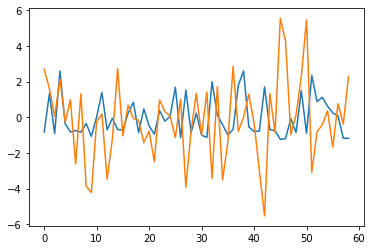










  2%|▏         | 1/50 [00:00<00:36,  1.35it/s]








  4%|▍         | 2/50 [00:01<00:31,  1.51it/s]








  6%|▌         | 3/50 [00:01<00:28,  1.65it/s]








  8%|▊         | 4/50 [00:02<00:26,  1.76it/s]








 10%|█         | 5/50 [00:02<00:25,  1.77it/s]








 12%|█▏        | 6/50 [00:03<00:24,  1.82it/s]








 14%|█▍        | 7/50 [00:03<00:23,  1.85it/s]








 16%|█▌        | 8/50 [00:04<00:22,  1.91it/s]








 18%|█▊        | 9/50 [00:04<00:21,  1.90it/s]








 20%|██        | 10/50 [00:05<00:20,  1.95it/s]








 22%|██▏       | 11/50 [00:05<00:20,  1.92it/s]








 24%|██▍       | 12/50 [00:06<00:19,  1.92it/s]








 26%|██▌       | 13/50 [00:06<00:18,  1.98it/s]








 28%|██▊       | 14/50 [00:07<00:17,  2.02it/s]








 30%|███       | 15/50 [00:07<00:17,  2.05it/s]








 32%|███▏      | 16/50 [00:08<00:16,  2.08it/s]








 34%|███▍      | 17/50 [00:08<00:15,  2.09it/s]








 36%|███▌      | 18/50 [00:09<00:15,  2.10it/s]


In [44]:
returns = run_GAN()

In [45]:
returns_generated = returns[0]
returns_true = returns[1]


In [55]:
returns_generated

[array([-0.83629394], dtype=float32),
 array([1.321731], dtype=float32),
 array([-0.90838873], dtype=float32),
 array([2.5921783], dtype=float32),
 array([-0.36082268], dtype=float32),
 array([-0.8271346], dtype=float32),
 array([-0.74790084], dtype=float32),
 array([-0.83640814], dtype=float32),
 array([-0.34889337], dtype=float32),
 array([-1.0715183], dtype=float32),
 array([0.01803376], dtype=float32),
 array([1.3942953], dtype=float32),
 array([-0.7075161], dtype=float32),
 array([-0.06049518], dtype=float32),
 array([-0.68992376], dtype=float32),
 array([-0.71052873], dtype=float32),
 array([0.22899228], dtype=float32),
 array([0.84391254], dtype=float32),
 array([-0.8603346], dtype=float32),
 array([0.47503525], dtype=float32),
 array([-0.49174243], dtype=float32),
 array([-0.95058495], dtype=float32),
 array([0.37380698], dtype=float32),
 array([-0.22047088], dtype=float32),
 array([0.0431072], dtype=float32),
 array([1.6859634], dtype=float32),
 array([-1.1534505], dtype=float

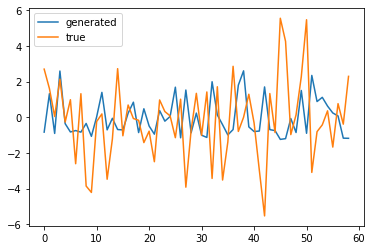

In [46]:
plt.plot(returns_generated, label = 'generated')
plt.plot(returns_true, label = 'true')
plt.legend()

In [72]:
#MAE
mean_absolute_error(returns_generated, returns_true)

2.0065200310505515

In [73]:
returns_percent_generated = returns_generated
returns_percent_true = returns_true

In [113]:
returns_percent_generated = returns_generated
returns_percent_true = returns_true
#trading strategy: buy if positive, nothing if negative
strategy_returns = []
for i in range (len(returns_percent_true)-2):
    if (returns_percent_generated[i][0] > 0):
        strategy_returns.append(returns_percent_true[i+1][0])
    else:
        strategy_returns.append(-1*returns_percent_true[i+1][0])

In [129]:
#eval strategy returns

#cumualtive reeturns real
cum_ret_real = [returns_percent_true[0]]
for i in range (1,len(returns_percent_true)):
    cum_ret_real.append(cum_ret_real[i-1]+returns_percent_true[i])
print ('cum ret real')
print (cum_ret_real)

#cumulative returns
cum_ret = [strategy_returns[0]]
for i in range (1,len(strategy_returns)):
    cum_ret.append(cum_ret[i-1]+strategy_returns[i])
print ('cum ret')
print (cum_ret)

#variance
variance = np.var(strategy_returns)
print ('variance')
print (variance)

print ('sharpe real')
#sharpe real
var = np.var(returns_percent_true)
rfr = 0
sharpe = (cum_ret_real[len(cum_ret_real)-1]- rfr)/var
print (sharpe)

print ('sharpe')
#sharpe
var = np.var(strategy_returns)
rfr = 0
sharpe = (cum_ret[len(cum_ret)-1] - rfr)/var
print (sharpe)

# #drawdown
# previous_peaks = np.maximum.accumulate(cum_ret)
# drawdown = (cum_ret-previous_peaks)/previous_peaks
# max_drawdown = np.ndarray.min(drawdown)
# print (max_drawdown)
# plt.plot(drawdown)

#turnover
turnover = 0
for pred in strategy_returns:
    if (pred > 0):
        turnover += 1
turnover = turnover/len(strategy_returns)
print (turnover)

cum ret real
[array([2.69910926]), array([4.30791667]), array([4.34836249]), array([6.48551356]), array([6.21339109]), array([7.19659561]), array([4.58900376]), array([5.90895479]), array([2.04795088]), array([-2.17108329]), array([-2.41159187]), array([-2.22619996]), array([-5.7046606]), array([-6.92510761]), array([-4.19993364]), array([-5.24029567]), array([-4.55481774]), array([-4.62649085]), array([-4.79816391]), array([-6.22057902]), array([-7.00250909]), array([-9.49818056]), array([-8.5296128]), array([-8.21032678]), array([-8.13426495]), array([-9.28144875]), array([-8.26897576]), array([-12.19241934]), array([-12.93427372]), array([-11.59381763]), array([-12.61296605]), array([-11.1951394]), array([-14.62797781]), array([-12.91779233]), array([-16.43969078]), array([-17.82673474]), array([-14.96985097]), array([-15.7656684]), array([-15.7656684]), array([-14.47631402]), array([-14.79319811]), array([-17.76313103]), array([-23.29928228]), array([-21.97043997]), array([-22.8276

In [126]:
print (np.average(returns_percent_true))

-0.1540705448534355


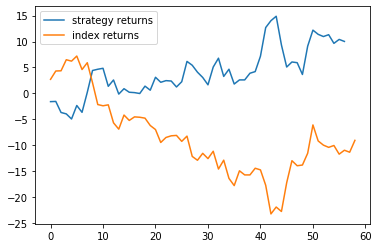

In [121]:
plt.plot(cum_ret, label = 'strategy returns')
plt.plot(cum_ret_real, label = 'index returns')
plt.legend()

In [ ]:
s

In [52]:
sharpe = (np.average(strategy_returns) - 1 - rfr)/std
print (sharpe)



[-0.73272649]


/Users/Nick/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


In [ ]:
np.var(strategy_returns)*100

In [ ]:
std